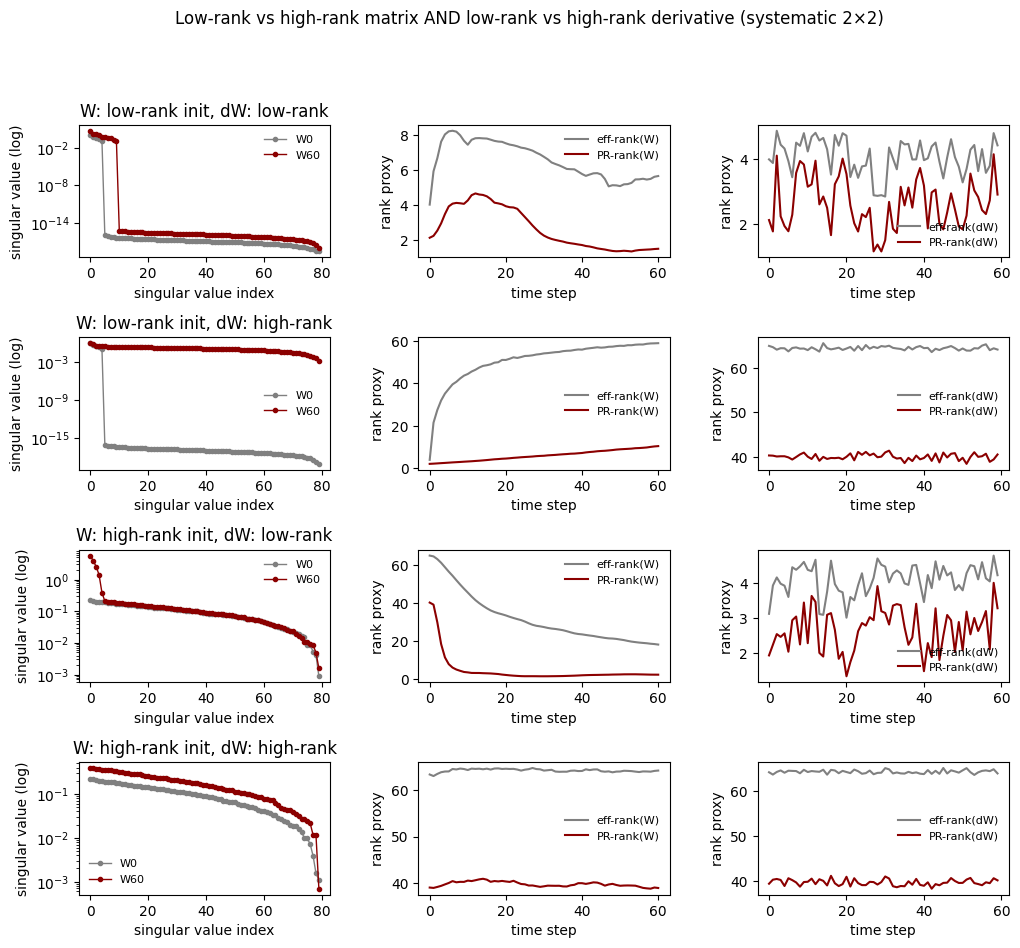

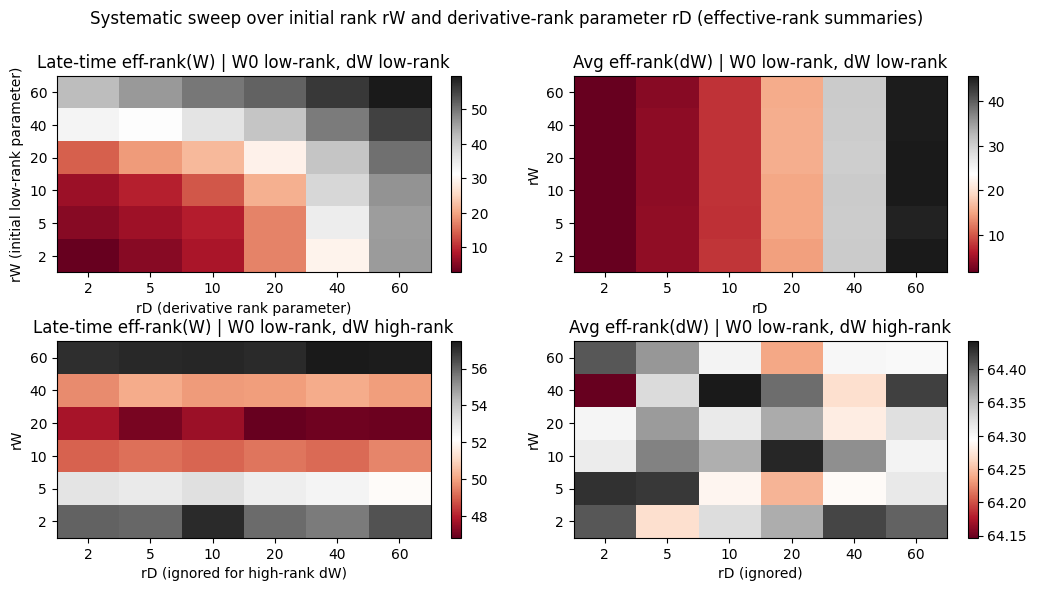

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Helpers
# ----------------------------
def low_rank_matrix(n, r, spectrum="exp", seed=None):
    rng = np.random.default_rng(seed)
    U, _ = np.linalg.qr(rng.standard_normal((n, r)))
    V, _ = np.linalg.qr(rng.standard_normal((n, r)))
    if spectrum == "exp":
        s = np.exp(-np.linspace(0, 2.0, r))
    elif spectrum == "flat":
        s = np.ones(r)
    else:
        s = np.linspace(1.0, 0.2, r)
    return U @ np.diag(s) @ V.T

def high_rank_matrix(n, seed=None):
    rng = np.random.default_rng(seed)
    W = rng.standard_normal((n, n))
    # give it a reasonably broad but not crazy spectrum
    W = (W + W.T) / 2.0
    W /= np.linalg.norm(W, ord='fro')
    return W

def low_rank_updates(n, rD, T, temporal_corr=0.9, seed=None):
    """
    ΔW_t = A diag(z_t) B^T, where A,B fixed -> changes are highly correlated (low-rank derivative).
    temporal_corr controls AR(1) correlation in z_t over time.
    """
    rng = np.random.default_rng(seed)
    A, _ = np.linalg.qr(rng.standard_normal((n, rD)))
    B, _ = np.linalg.qr(rng.standard_normal((n, rD)))
    z = rng.standard_normal(rD)
    updates = []
    for t in range(T):
        z = temporal_corr * z + np.sqrt(max(1e-12, 1 - temporal_corr**2)) * rng.standard_normal(rD)
        dW = A @ np.diag(z) @ B.T
        dW /= np.linalg.norm(dW, ord='fro') + 1e-12
        updates.append(dW)
    return np.stack(updates, axis=0)

def high_rank_updates(n, T, temporal_corr=0.0, seed=None):
    """
    ΔW_t ~ full-rank Gaussian (optionally with mild temporal correlation).
    """
    rng = np.random.default_rng(seed)
    dW_prev = np.zeros((n, n))
    updates = []
    for t in range(T):
        dW = rng.standard_normal((n, n))
        dW = (dW + dW.T) / 2.0
        dW = temporal_corr * dW_prev + (1 - temporal_corr) * dW
        dW_prev = dW
        dW /= np.linalg.norm(dW, ord='fro') + 1e-12
        updates.append(dW)
    return np.stack(updates, axis=0)

def effective_rank_from_svals(s, eps=1e-12):
    """
    Effective rank (entropy-based): exp(H(p)), p_i = s_i / sum s_i
    """
    s = np.maximum(s, 0)
    p = s / (np.sum(s) + eps)
    H = -np.sum(p * np.log(p + eps))
    return float(np.exp(H))

def participation_ratio_from_svals(s, eps=1e-12):
    """
    Participation ratio on squared singular values: (sum λ)^2 / sum λ^2
    with λ = s^2
    """
    lam = s**2
    return float((np.sum(lam)**2) / (np.sum(lam**2) + eps))

def svd_metrics(W):
    s = np.linalg.svd(W, compute_uv=False)
    return {
        "s": s,
        "erank": effective_rank_from_svals(s),
        "prank": participation_ratio_from_svals(s),
    }

# ----------------------------
# Core simulation
# ----------------------------
def simulate(n=80, T=60, step=0.15, rW=5, rD=5, 
             W_rank="low", dW_rank="low", seed=0):
    rng = np.random.default_rng(seed)
    # Initial matrix
    if W_rank == "low":
        W0 = low_rank_matrix(n, rW, seed=seed)
    else:
        W0 = high_rank_matrix(n, seed=seed)
    W = W0.copy()
    
    # Updates
    if dW_rank == "low":
        dWs = low_rank_updates(n, rD, T, temporal_corr=0.9, seed=seed+1)
    else:
        dWs = high_rank_updates(n, T, temporal_corr=0.0, seed=seed+1)
    
    Ws = [W.copy()]
    dW_metrics = []
    W_metrics = [svd_metrics(W)]
    
    for t in range(T):
        dW = dWs[t]
        W = W + step * dW
        Ws.append(W.copy())
        dW_metrics.append(svd_metrics(dW))
        W_metrics.append(svd_metrics(W))
    
    return np.stack(Ws, axis=0), dWs, W_metrics, dW_metrics

# ----------------------------
# Demo: 2x2 conditions
# ----------------------------
n = 80
T = 60
r_low = 5
step = 0.2

conds = [
    ("low", "low"),
    ("low", "high"),
    ("high", "low"),
    ("high", "high"),
]

results = {}
for i, (Wr, dWr) in enumerate(conds):
    Ws, dWs, Wm, dWm = simulate(n=n, T=T, step=step, rW=r_low, rD=r_low, W_rank=Wr, dW_rank=dWr, seed=10+i)
    results[(Wr, dWr)] = (Ws, dWs, Wm, dWm)

# Plot: singular spectra + effective-rank trajectories
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 3, hspace=0.6, wspace=0.35)

for row, (Wr, dWr) in enumerate(conds):
    Ws, dWs, Wm, dWm = results[(Wr, dWr)]
    
    # (1) singular values of W0 and W_T
    ax1 = fig.add_subplot(gs[row, 0])
    s0 = Wm[0]["s"]
    sT = Wm[-1]["s"]
    ax1.semilogy(s0, marker='o', linestyle='-', linewidth=1, markersize=3, label="W0", color = 'gray')
    ax1.semilogy(sT, marker='o', linestyle='-', linewidth=1, markersize=3, label=f"W{T}", color = 'darkred')
    ax1.set_title(f"W: {Wr}-rank init, dW: {dWr}-rank")
    ax1.set_xlabel("singular value index")
    ax1.set_ylabel("singular value (log)")
    ax1.legend(frameon=False, fontsize=8)
    
    # (2) effective rank over time
    ax2 = fig.add_subplot(gs[row, 1])
    erW = [m["erank"] for m in Wm]
    prW = [m["prank"] for m in Wm]
    ax2.plot(erW, linewidth=1.5, label="eff-rank(W)", color = 'gray')
    ax2.plot(prW, linewidth=1.5, label="PR-rank(W)", color = 'darkred')
    ax2.set_xlabel("time step")
    ax2.set_ylabel("rank proxy")
    ax2.legend(frameon=False, fontsize=8)
    
    # (3) derivative ranks over time
    ax3 = fig.add_subplot(gs[row, 2])
    erdW = [m["erank"] for m in dWm]
    prdW = [m["prank"] for m in dWm]
    ax3.plot(erdW, linewidth=1.5, label="eff-rank(dW)", color = 'gray')
    ax3.plot(prdW, linewidth=1.5, label="PR-rank(dW)", color = 'darkred')
    ax3.set_xlabel("time step")
    ax3.set_ylabel("rank proxy")
    ax3.legend(frameon=False, fontsize=8)

plt.suptitle("Low-rank vs high-rank matrix AND low-rank vs high-rank derivative (systematic 2×2)", y=0.995)
plt.savefig("fig_rank_derivative_2x2.pdf", bbox_inches="tight")
plt.show()

# ----------------------------
# Systematic sweep: (rW, rD) -> average ranks
# ----------------------------
n = 80
T = 50
step = 0.15
r_grid = [2, 5, 10, 20, 40, 60]

def sweep(W_rank, dW_rank, seed_base=0):
    avg_erW = np.zeros((len(r_grid), len(r_grid)))
    avg_erdW = np.zeros((len(r_grid), len(r_grid)))
    for i, rW in enumerate(r_grid):
        for j, rD in enumerate(r_grid):
            Ws, dWs, Wm, dWm = simulate(n=n, T=T, step=step, rW=rW, rD=rD, W_rank=W_rank, dW_rank=dW_rank, seed=seed_base + 100*i + j)
            avg_erW[i, j] = np.mean([m["erank"] for m in Wm[-10:]])  # late-time average
            avg_erdW[i, j] = np.mean([m["erank"] for m in dWm])      # average derivative eff-rank
    return avg_erW, avg_erdW

# show two illustrative sweeps: low-rank init vs high-rank init while varying derivative rank
avg_erW_LL, avg_erdW_LL = sweep("low", "low", seed_base=1)
avg_erW_LH, avg_erdW_LH = sweep("low", "high", seed_base=2)

fig2 = plt.figure(figsize=(12, 6))
gs2 = fig2.add_gridspec(2, 2, hspace=0.35, wspace=0.25)

ax = fig2.add_subplot(gs2[0, 0])
im = ax.imshow(avg_erW_LL, aspect='auto', origin='lower', cmap='RdGy')
ax.set_title("Late-time eff-rank(W) | W0 low-rank, dW low-rank")
ax.set_xticks(range(len(r_grid))); ax.set_xticklabels(r_grid)
ax.set_yticks(range(len(r_grid))); ax.set_yticklabels(r_grid)
ax.set_xlabel("rD (derivative rank parameter)")
ax.set_ylabel("rW (initial low-rank parameter)")
plt.colorbar(im, ax=ax, fraction=0.046)

ax = fig2.add_subplot(gs2[0, 1])
im = ax.imshow(avg_erdW_LL, aspect='auto', origin='lower', cmap='RdGy')
ax.set_title("Avg eff-rank(dW) | W0 low-rank, dW low-rank")
ax.set_xticks(range(len(r_grid))); ax.set_xticklabels(r_grid)
ax.set_yticks(range(len(r_grid))); ax.set_yticklabels(r_grid)
ax.set_xlabel("rD")
ax.set_ylabel("rW")
plt.colorbar(im, ax=ax, fraction=0.046)

ax = fig2.add_subplot(gs2[1, 0])
im = ax.imshow(avg_erW_LH, aspect='auto', origin='lower', cmap='RdGy')
ax.set_title("Late-time eff-rank(W) | W0 low-rank, dW high-rank")
ax.set_xticks(range(len(r_grid))); ax.set_xticklabels(r_grid)
ax.set_yticks(range(len(r_grid))); ax.set_yticklabels(r_grid)
ax.set_xlabel("rD (ignored for high-rank dW)")
ax.set_ylabel("rW")
plt.colorbar(im, ax=ax, fraction=0.046)

ax = fig2.add_subplot(gs2[1, 1])
im = ax.imshow(avg_erdW_LH, aspect='auto', origin='lower', cmap='RdGy')
ax.set_title("Avg eff-rank(dW) | W0 low-rank, dW high-rank")
ax.set_xticks(range(len(r_grid))); ax.set_xticklabels(r_grid)
ax.set_yticks(range(len(r_grid))); ax.set_yticklabels(r_grid)
ax.set_xlabel("rD (ignored)")
ax.set_ylabel("rW")
plt.colorbar(im, ax=ax, fraction=0.046)


plt.suptitle("Systematic sweep over initial rank rW and derivative-rank parameter rD (effective-rank summaries)", y=0.99)
plt.savefig("fig_rank_derivative_sweep.pdf", bbox_inches="tight")
plt.show()
